In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Signal + Noise

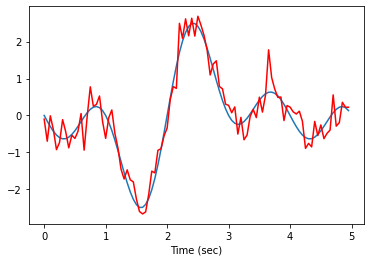

In [20]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.05      # total 250 seconds

t = np.arange(0, (num_train_data+num_test_data)*timestep, timestep)
d = np.sin(np.pi*t) + np.sin(-np.pi/2*t) + np.sin((-3*np.pi/2)*t)

SNR = 10
y_noise = d + np.random.normal(0, 10**(-SNR/20), len(d))  # mean and standard deviation

plt.plot(t[:100], d[:100])
plt.plot(t[:100], y_noise[:100], 'r')
plt.xlabel("Time (sec)")
plt.show()

# LMS filter

In [21]:
# set parameters
mu = 0.01
M = 10
wn = np.zeros(M)
ylms = np.zeros(len(d))

In [22]:
for k in range(M, len(y_noise)):
    ylms[k] = np.dot(wn, y_noise[k-M:k])
    e = y_noise[k] - ylms[k]
    wn = wn + mu * y_noise[k-M:k] * e

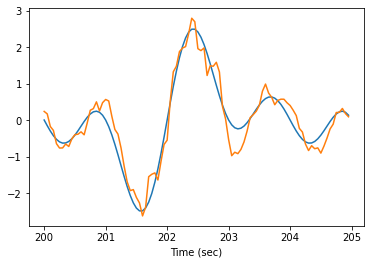

In [23]:
plt.plot(t[4000:4100], d[4000:4100])
plt.plot(t[4000:4100], ylms[4000:4100])
plt.xlabel("Time (sec)")
plt.show()

In [24]:
lms_err = ylms[num_train_data:] - d[num_train_data:]

# RLS filter

In [46]:
# set parameters
lambd = 0.75
delta = 0.1
M = 2
wn = np.zeros((1, M))
xn = np.concatenate((y_noise[0].reshape(1, -1), np.zeros((1, M-1))), axis=None).reshape(1, -1)
P = delta**-1 * np.identity(M)
yrls = np.zeros(len(d))

In [47]:
for k in range(1, len(y_noise)):
    xn = np.concatenate((y_noise[k].reshape(1, -1), xn), axis=None)[:M].reshape(1, -1)
    kn = (lambd**-1 * np.dot(P, xn.T)) / (1 + lambd**-1 * np.dot(xn, np.dot(P, xn.T)))
    xi = y_noise[k] - np.dot(wn, xn.T)
    wn = wn + kn.T * xi
    yrls[k] = np.dot(wn, xn.T)
    P = lambd**-1 * P - lambd**-1 * np.dot(kn, np.dot(xn, P))

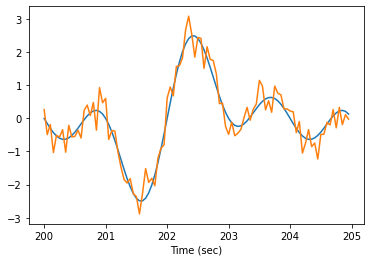

In [48]:
plt.plot(t[4000:4100], d[4000:4100])
plt.plot(t[4000:4100], yrls[4000:4100])
plt.xlabel("Time (sec)")
plt.show()

In [49]:
rls_err = yrls[num_train_data:] - d[num_train_data:]

# DNN

In [12]:
# training data
num_inputs = 64
train_data = []
train_labels = []
for k in range(num_train_data-num_inputs-1):
    train_data.append(y_noise[k:k+num_inputs].tolist())
    train_labels.append(y_noise[k+num_inputs].tolist())

In [13]:
# model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.relu,
                           input_shape=(num_inputs,)),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

# compile network
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              loss="mse",
              metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(train_data, train_labels, epochs=60)

Epoch 1/60
123/123 [==============================] - 1s 2ms/step - loss: 0.2422 - mae: 0.3784
Epoch 2/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1491 - mae: 0.3077
Epoch 3/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2957
Epoch 4/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.2865
Epoch 5/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.2778
Epoch 6/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1199 - mae: 0.2756
Epoch 7/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1180 - mae: 0.2738
Epoch 8/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1142 - mae: 0.2696
Epoch 9/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1119 - mae: 0.2670
Epoch 10/60
123/123 [==============================] - 0s 2ms/step - loss: 0.1120 - mae: 0.2665
Epoch 11/60
123/123 [============================

In [15]:
# testing data
test_data = []
for k in range(num_train_data-num_inputs, num_train_data+num_test_data-num_inputs):
    test_data.append(y_noise[k:k+num_inputs].tolist())

In [16]:
pred = model.predict(test_data)

32/32 [==============================] - 0s 2ms/step


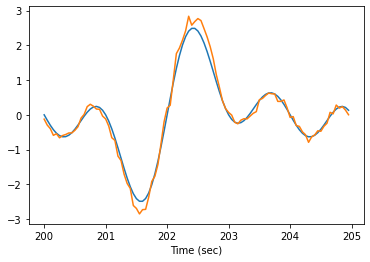

In [30]:
t0 = num_train_data
plt.plot(t[t0:t0+100], d[t0:t0+100])
plt.plot(t[t0:t0+100], pred.flatten()[:100])
plt.xlabel("Time (sec)")
plt.show()

In [18]:
dnn_err = np.array(d[num_train_data:]) - pred.flatten()

# Error comparison
$10\log_{10}\sum_n (d(n)-\hat{y}(n))^2$

In [50]:
print("LMS error: {:.3f}".format(10*np.log10(np.sum(lms_err**2))))
print("RLS error: {:.3f}".format(10*np.log10(np.sum(rls_err**2))))
print("DNN error: {:.3f}".format(10*np.log10(np.sum(dnn_err**2))))

LMS error: 19.487
RLS error: 20.071
DNN error: 13.662
